## Car Price Prediction

The problem at hand is to model the selling price of used cars based on the features given in the datasets. It will be used by the client to predict the price of a car of their choice. Your mission, should you choose to accept it, as a data scientist, is to make sure that you maximize the probability of them getting the car and at the same time, make sure that they don't overpay.


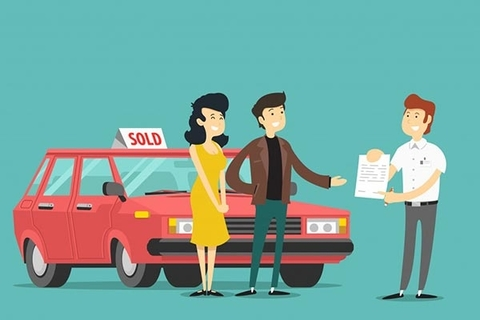

Let's get to it.

In [ ]:
import numpy as np
import pandas as pd
import plotly.express as px
from datetime import date

In [ ]:
import warnings
warnings.filterwarnings('ignore')

## A Look At The Data

In [ ]:
model_df = pd.read_csv('/kaggle/input/used-car-price-data/model_data.csv')
car_df = pd.read_csv('/kaggle/input/used-car-price-data/car_data.csv')

In [ ]:
car_df.head()

In [ ]:
model_df.head()

Looking at the two datasets, the model column in the two dataframes can be used to merge the two such that you can have a dataframe with information of each car with its current selling price.

In [ ]:
df = pd.merge(car_df, model_df, left_on='Model', right_on='Model')

You can look at the two datasets together now.

In [ ]:
df.describe(include='all')

Checking for null values if any.

In [ ]:
df.isna().mean()*100

We have very few null values in Insurance and Car Price columns.

In [ ]:
fig = px.histogram(df, 'Selling Price')
fig.show()

There are a few records with 0 selling price. Maybe, you can get that car for free. We all know that is not possible so we can go ahead and remove these records.

In [ ]:
df = df[df['Selling Price'] != 0]

Current Price column is in very raw format. Some of the records have Rs. prefix and a Lakh at the end while some are in all numbers. You need to convert it to integer format so that you can analyze it better and compare with the selling price column.

In [ ]:
def format_price(price):
    price = str(price)
    price = price.replace('Rs.', '')
    price = price.replace(',', '')
    num_zeros = 5
    if '.' not in price and ' Lakh' in price:
        price = price.replace(' Lakh', '0'*num_zeros)
    elif '.' in price and ' Lakh in price':
        n = len(price)
        m = price.index('.')
        num_zeros = n - m - num_zeros
        price = price.replace(' Lakh', '0'*num_zeros)
        price = price.replace('.', '')
    return price

In [ ]:
df['Current Price'] = df['Current Price'].apply(format_price)
df[df['Current Price'] == 'nan'] = 0
df['Current Price'] = df['Current Price'].astype(int)

In [ ]:
fig = px.histogram(df, 'Current Price')
fig.show()

Woah! you have some cars that have 0 Current Price. Looks like the earlier null count were deceptive as you already know, no one is giving away cars for free. You might have to handle this.

In [ ]:
year = date.today().year
df['Age'] = year - df['Year']

In [ ]:
df = df[df['Selling Price'] != 0]
fig = px.scatter(x=df['Age'], y=df['Kilometers Driven'])
fig.show()

In [ ]:
fig = px.scatter(x=df['Kilometers Driven'], y=df['Selling Price'])
fig.show()

In [ ]:
fig = px.scatter(x=df['Age'], y=df['Selling Price'])
fig.show()

In [ ]:
fig = px.scatter(df['Selling Price'], color=df['Owner'])
fig.show()

In [ ]:
df['Transmission'].unique()

Transmission column has many values other than manual or automatic. You need to handle this and one way to do it can be to replace all of them with the mode (the most frequent value). That is MANUAL in this case.

In [ ]:
def clean_transmission(trans):
    
    if 'MANUAL' != trans and 'AUTOMATIC' != trans:
        trans = "MANUAL"
    
    return trans

df['Transmission'] = df['Transmission'].apply(clean_transmission)

Insurance column had some null values. let's replace them with the most frequent value.

In [ ]:
from sklearn.impute import SimpleImputer

mode_imputer = SimpleImputer(strategy="most_frequent")
df['Insurance'] = mode_imputer.fit_transform(df['Insurance'].values.reshape(-1, 1))

Let's derive a feature from the insurance column, to indicate whether the insurance has expired or not.

In [ ]:
df['Insurance_Expired'] = 0
df.loc[df['Insurance'] == 'Expired', 'Insurance_Expired'] = 1

In [ ]:
fig = px.scatter(df['Selling Price'], color=df['Insurance_Expired'])
fig.show()

In [ ]:
fig = px.scatter(x=df['Current Price'], y=df['Selling Price'], color=df['Car Condition'])
fig.show()

## Cleaning data

The Current Price column had some records with 0 value. We can add the average difference between the selling price and current price to the selling price of these columns to get an approximation of the current price of these columns.

You can also add another column to tell the model that the current price was missing earlier and to take the current price for such records with a pinch of salt. As missing current price might denote that the car is too old and no longer sold in the market

In [ ]:
df['No_Current_Price'] = 0
df.loc[df['Current Price'] == 0, 'No_Current_Price'] = 1

In [ ]:
df['diff'] = df['Current Price'] - df['Selling Price']

Since the prices are bit skewed, median is better approximation of central tendency.

In [ ]:
med_diff = df[df['diff'] > 0]['diff'].median()

In [ ]:
def set_current_price(row):
    if row['Current Price'] == 0 or row['diff'] < 0:
        row['Current Price'] = row['Selling Price'] + med_diff
    
    return row['Current Price']

df.loc[:, 'Current Price'] = df.apply(set_current_price, axis=1)

In [ ]:
df.head()

You can now drop model, year, insurance and diff columns

In [ ]:
df.drop(['Model', 'Year', 'Insurance', 'diff'], axis=1, inplace=True)
df.head()

Separating the target features

In [ ]:
X = df.drop(['Selling Price'], axis=1)
y = df.loc[:, 'Selling Price']

Creating a Train Test split

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

## Preprocessing

In [ ]:
num_attribs = ['Kilometers Driven', 'Car Condition', 'Current Price', 'Age']
cat_attribs = ['Owner', 'Fuel Type', 'Transmission']

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

preprocessing = ColumnTransformer([
    ("num", StandardScaler(), num_attribs),
    ("cat", OneHotEncoder(drop='first', sparse=False), cat_attribs)
], remainder="passthrough")

X_train = preprocessing.fit_transform(X_train)

We can extract column names to later check which feature affect our target feature the most.

In [ ]:
col_names = []
for transformer_tuple in preprocessing.transformers_[:-1]:
    cols = transformer_tuple[2]
    transformer = transformer_tuple[1]
    try:
        cols = transformer.get_feature_names(cols)
    except AttributeError:
        cols = cols
        
    col_names += list(cols)
    
col_names += list(X.columns[preprocessing.transformers_[2][2]])

In [ ]:
sc_y = StandardScaler()
y_train = sc_y.fit_transform(y_train.values.reshape(-1, 1))

## Training Different Models

In [ ]:
from sklearn.model_selection import cross_val_score

def evaluate_model(model, X, y):
    
    model.fit(X, y)
    
    accuracies = cross_val_score(estimator = model, X = X, y = y, cv = 10)
    print(model.__class__.__name__)
    print("Accuracy: {:.2f} %".format(accuracies.mean()*100))
    print("Standard Deviation: {:.2f} %".format(accuracies.std()*100))
    
    return model

In [ ]:
from sklearn.linear_model import LinearRegression

lin_reg = evaluate_model(LinearRegression(), X_train, y_train)

In [ ]:
from sklearn.svm import SVR

svr = evaluate_model(SVR(), X_train, y_train)

In [ ]:
from sklearn.ensemble import RandomForestRegressor

rf = evaluate_model(RandomForestRegressor(n_estimators = 100, random_state = 0), X_train, y_train)

In [ ]:
from sklearn.ensemble import AdaBoostRegressor

ada_boost = evaluate_model(AdaBoostRegressor(random_state=0, n_estimators=100), X_train, y_train)

In [ ]:
import xgboost

xg_boost = evaluate_model(xgboost.XGBRegressor(), X_train, y_train)

In [ ]:
from sklearn.model_selection import GridSearchCV

param_test = {
 'max_depth':[4,5,6],
 'min_child_weight':[4,5,6],
 'colsample_bytree':[i/100.0 for i in range(75,90,5)]
}

grid_search_1 = GridSearchCV(estimator = xgboost.XGBRegressor(learning_rate =0.1,
                                                              n_estimators=10,
                                                              max_depth=5,
                                                              min_child_weight=1,
                                                              gamma=0.2,
                                                              subsample=0.85,
                                                              colsample_bytree=0.8),
                             param_grid = param_test,
                             scoring='neg_mean_squared_error',
                             n_jobs=-1,
                             cv=5)

grid_search_1.fit(X_train,y_train)
grid_search_1.best_params_, grid_search_1.best_score_

Note: Hyperparamter tuning can be an iterative technique where you first do a coarse search of parameter values and then go for a finer search around the values found in the previous step. In interest of your time, I have only included the last step here.

In [ ]:
xg_boost = evaluate_model(xgboost.XGBRegressor(learning_rate =0.1,
                                                              n_estimators=100,
                                                              max_depth=6,
                                                              min_child_weight=6,
                                                              gamma=0.2,
                                                              subsample=0.85,
                                                              colsample_bytree=0.85),
                          X_train, y_train)

In [ ]:
importance_df = pd.DataFrame(xg_boost.feature_importances_)
importance_df['Features'] = col_names
importance_df = importance_df.rename(columns={0 : 'Average Importance'})

fig = px.bar(importance_df, x='Features', y='Average Importance')
fig.show()

In [ ]:
X_test = preprocessing.transform(X_test)
y_test = sc_y.transform(y_test.values.reshape(-1, 1))

y_pred = xg_boost.predict(X_test)

In [ ]:
from sklearn.metrics import mean_squared_error

mean_squared_error(y_test, y_pred)

Here, fuel type, age, current price and car condition are the features that contribute the most in determining the target features as we would have assumed.

***I hope you found this notebook interesting. I would love to read your feedbacks below.***